## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is cleaned up a bit from the original code that I hacked together, and is only lightly commented. I wrote the code to be easy to interpret and understand, even for those who are new to Python. I tried never to be clever or even more efficient at the cost of being harder to understand. The code is in Python3, using the versions of libraries as of April 2021. 

This notebook may contain additional code to create models and images not in the book. That material is included here to demonstrate additional techniques.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

## Chapter 23: Creative Applications - Notebook 1: Deep Dreaming

### About this code:
This notebook is adapted from
https://keras.io/examples/generative/deep_dream/

Another TensorFlow-based implementation is available at
https://www.tensorflow.org/tutorials/generative/deepdream

In the book I discuss this method using VGG16. This notebook uses the InceptionV3 network instead. It's larger than VGG16, and often produces more interesting results. You can modify this code to use VGG16 if you prefer.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3

In [2]:
# Workaround for Keras issues on Mac computers (you can comment this
# out if you're not on a Mac, or not having problems)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## User Settings 
Use these to select the image to dream on, and how to process it.

First, the dictionary `layer_settings` lets us
state the names of the layers that we measure to compute the loss.
For each layer, we assign how much weight, or influence, it has on the final.
A larger weight means more influence. You need at least one layer, but everything
else is up to your personal taste: how many layers, which layers, and what weights
to assign to them. You can produce dramatically different effects by modifying
these choices.

There are lots of layers to pick from in the Inception network. To see
what they're named, uncomment the line for `model.summary()` a few cells
below, just after we make the model. But generally we use the layers that
begin with `mixed`, which have the names `mixed0` through `mixed10`. The
layers with smaller numbers are earlier in the network, and focus on
finer-grained features. 

After that we have a set of five parameters that let us tune the algorithm.
Again, play with these and discover combinations that work for you.
The algorithm here is a bit fancier than the basic description in the book,
and processes the image a few times at different resolutions, or "octaves".
Generally speaking, smaller values for `step` and `iterations` will 
produce more subtle effects (but take longer), and larger values for
`num_octave` and `octave_scale` will produce more complex effects (but
again, will take longer).

Finally, we have the name of the input image that we'll use for dreaming,
and the prefix for the output image.

In [3]:
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}

layer_settings = {
    "mixed3": 0.5,
    "mixed5": 2.5,
    "mixed7": 3.5,
    "mixed9": 16.5,
}

# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale
max_loss = 15.0

base_image_path = 'input_data/waters-3038803_1280-crop.jpg'
result_prefix = "saved_output/frog_dream"

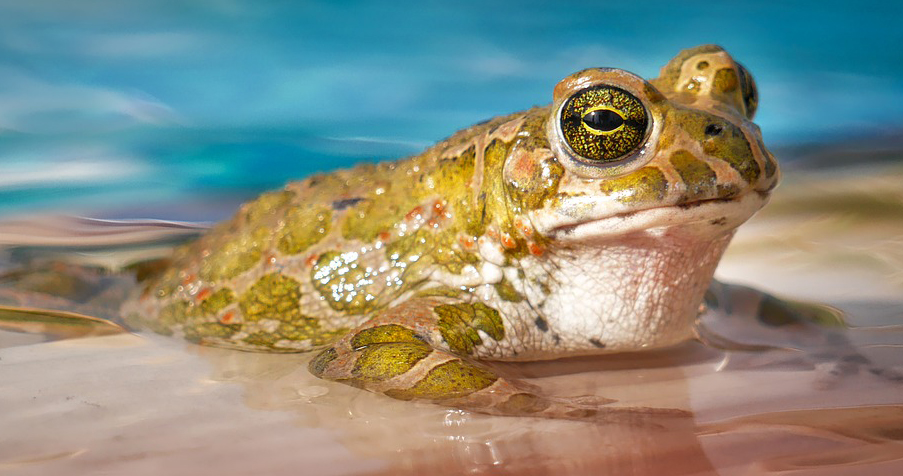

In [4]:
# Show the starting image

from IPython.display import Image, display

display(Image(base_image_path))

These utilties get the image into and out of the formats that work for this convnet

In [5]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate arrays.
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a NumPy array into a valid image.
    x = x.reshape((x.shape[1], x.shape[2], 3))
    # Undo inception v3 preprocessing
    x /= 2.0
    x += 0.5
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x


Build a feature extraction model to retrieve the activations of our target layers given an input image.

In [6]:
# Build an InceptionV3 model loaded with pre-trained ImageNet weights
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

# If you'd like to see the names of the layers, uncomment this line
#model.summary()

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)

# Set up a model that returns the activation values for every target layer
# (as a dict)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

Compute the loss for the image

In [7]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    # Initialize the loss
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        # We avoid border artifacts by only involving non-border pixels in the loss.
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32"))
        loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling
    return loss


Some fancy Python to build the gradient ascent for one octave in an efficient way,
using a decorator on the Tensorflow function so it gets compiled.

In [8]:

@tf.function
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
    img += learning_rate * grads
    return loss, img


def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, img = gradient_ascent_step(img, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print("... Loss value at step %d: %.2f" % (i, loss))
    return img

Now train! Loop over the different octaves.

In [9]:

original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)  # Make a copy
for i, shape in enumerate(successive_shapes):
    print("Processing octave %d with shape %s" % (i, shape))
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.preprocessing.image.save_img(result_prefix + ".png", deprocess_image(img.numpy()))

Processing octave 0 with shape (242, 460)
... Loss value at step 0: 0.84
... Loss value at step 1: 1.20
... Loss value at step 2: 1.24
... Loss value at step 3: 1.54
... Loss value at step 4: 1.75
... Loss value at step 5: 1.85
... Loss value at step 6: 2.41
... Loss value at step 7: 2.44
... Loss value at step 8: 2.60
... Loss value at step 9: 3.04
... Loss value at step 10: 3.28
... Loss value at step 11: 3.59
... Loss value at step 12: 3.55
... Loss value at step 13: 4.04
... Loss value at step 14: 4.11
... Loss value at step 15: 4.23
... Loss value at step 16: 4.63
... Loss value at step 17: 4.72
... Loss value at step 18: 5.53
... Loss value at step 19: 5.73
Processing octave 1 with shape (340, 645)
... Loss value at step 0: 1.24
... Loss value at step 1: 1.63
... Loss value at step 2: 2.25
... Loss value at step 3: 2.19
... Loss value at step 4: 2.66
... Loss value at step 5: 2.97
... Loss value at step 6: 3.16
... Loss value at step 7: 3.24
... Loss value at step 8: 3.02
... Los

Show the glorious results. If you don't love them, change the parameters up top and try again!

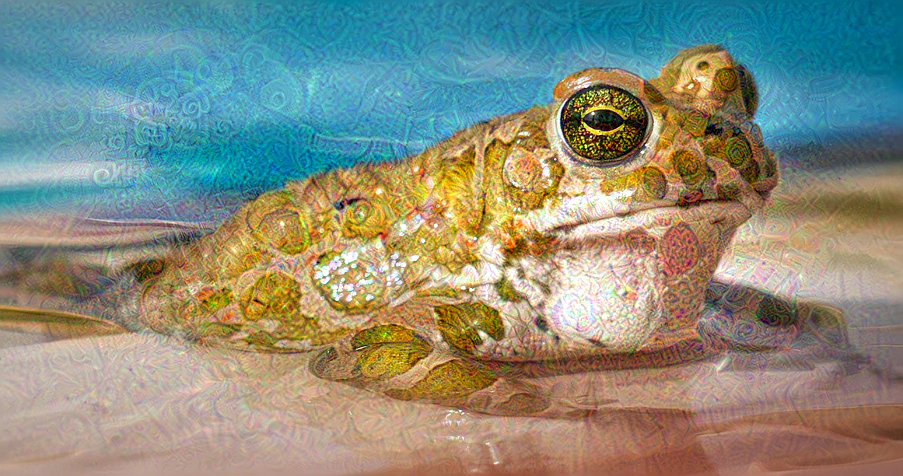

In [10]:
display(Image(result_prefix + ".png"))